### PART B: Image Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Load the CIFAR10 small images classification dataset from Keras inbuilt datasets
(https://keras.io/api/datasets/cifar10/). Display 10 random images from each of the 10
classes (the images should change in every run).

In [3]:
#Libraries to be imported

import cv2
import numpy as np
from sklearn.model_selection import KFold
from keras.datasets import cifar10 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import tensorflow as tf

In [4]:
# load dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
#Summerize loaded dataset

print("Shape of training data:")
print(trainX.shape)
print(trainY.shape)
print("Shape of test data:")
print(testX.shape)
print(testY.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


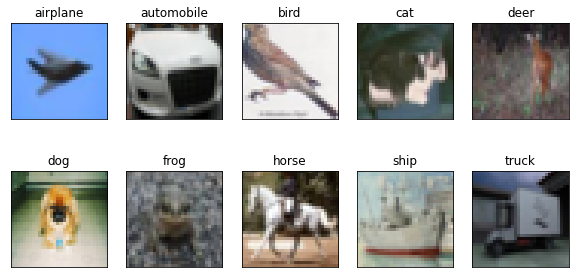

In [6]:
# defining the name for each class
cifar10_classes = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog',
        'frog', 'horse', 'ship', 'truck']

# Print figure with 10 random images from each class

fig = plt.figure(figsize=(10,5)) #specify figure size
for i in range(10): # for each of the 10 categories
    img = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[]) #add plot to figure, specify 2 rows, 5 columns from position 1 
    img.set_title(cifar10_classes[i]) # set the title from the list
    idx = np.where(trainY[:]==i)[0] # returning elements from trainY and assign to i starting from index 0 = classes
    img_idx = trainX[idx,::] 
    img_num = np.random.randint(img_idx.shape[0]) # return random integers 
    plt.imshow(img_idx[img_num,::]) #within each category, display random images
plt.show()

### 2. For the classification (10 image classes), write Python code to create a basic CNN network of your choice 
        (can be anything from practical 7, LeNet, AlexNet etc.)

#### Data Preparation

In [7]:
#Encode the loaded data

def encode_Ydata(Ytrain, Ytest):

    # Transform label indices to one-hot encoded vector
    Ytrain = to_categorical(Ytrain)
    Ytest = to_categorical(Ytest)
    
    # return encoded labels
    return Ytrain, Ytest

train_Y, test_Y = encode_Ydata(trainY, testY)

In [8]:
# scale pixels

def norm_pixels(train, test): #input to the function
    
    # convert from integers to floats and normalize to range 0-1
    train_norm = train.astype('float32')/255
    test_norm = test.astype('float32')/255
    
    # return normalized images
    return train_norm, test_norm

train_X, test_X = norm_pixels(trainX, testX)

#### Define model

In [9]:
#Define cnn model

def define_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = define_model()

### 3. Train and test the network and report the training loss, training accuracy and test accuracy for various   epochs

In [10]:
# Training and evaluate a model using k-fold cross-validation

def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        
        # define model
        model = define_model()
    
        # select rows for train and test
        train_X, train_Y, test_X, test_Y = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    
        # fit model
        history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_data=(test_X, test_Y), verbose=0)
    
        # evaluate model
        _, acc = model.evaluate(test_X, test_Y, verbose=0)
        print('> %.3f' % (acc * 100.0))
    
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories


In [11]:
# evaluate model - accuracy of each fold
scores, histories = evaluate_model(test_X, test_Y) 

> 50.050
> 52.800
> 50.150
> 48.700
> 47.850


In [12]:
#Average of the 5 folds

print('Accuracy: mean=%.3f' % (np.mean(scores)*100))

Accuracy: mean=49.910


In [13]:
# Adjust figure sizes

plt.rcParams['figure.figsize'] = [8, 6]

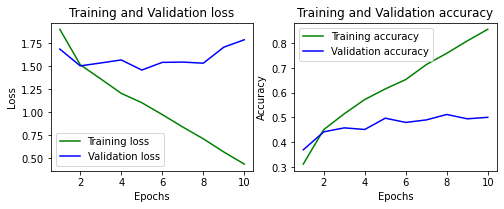

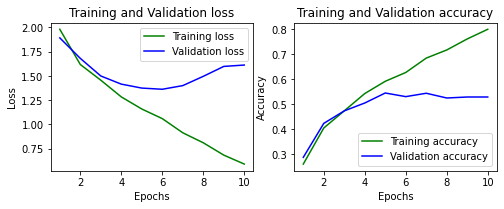

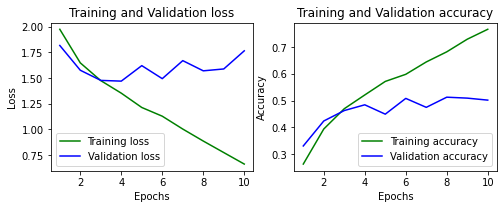

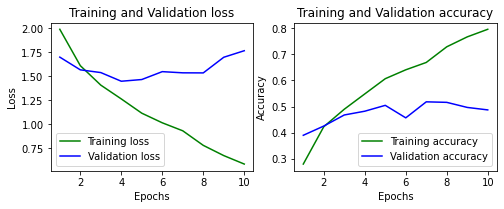

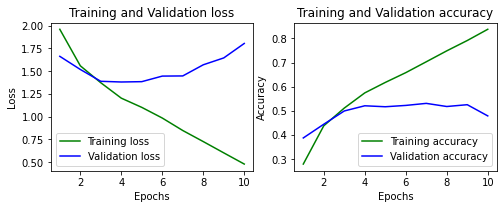

In [14]:
#Report losses and accuracy 
def loses_acc(history):
    for i in range(len(histories)):
        
        # Plot loss and val loss
        plt.subplot(221)
        loss_train = histories[i].history['loss']
        loss_val = histories[i].history['val_loss']
        epochs = range(1,11)
        plt.plot(epochs, loss_train, 'g', label='Training loss')
        plt.plot(epochs, loss_val, 'b', label='Validation loss')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        
        #Plot accuracy and val acc
        plt.subplot(222)
        loss_train = histories[i].history['accuracy']
        loss_val = histories[i].history['val_accuracy']
        epochs = range(1,11)
        plt.plot(epochs, loss_train, 'g', label='Training accuracy')
        plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()
        
loses_acc(histories)  

### 4. Improve the architecture by changing the parameters
including but not limited to, learning rate, epochs, size of the convolution filters, use of average pooling or max-pooling etc.

In [15]:
#Define improved model

def define_improved_model():

    improved_model = Sequential()
    #increase the output channels to 64 
    improved_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
    improved_model.add(MaxPool2D((2, 2)))
    improved_model.add(Flatten())
    #increase output channels to 128
    improved_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    improved_model.add(Dense(10, activation='softmax'))

    
# compile model
    opt = SGD(lr=0.01, momentum=0.9) 
    improved_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return improved_model

In [16]:
# evaluate a model using k-fold cross-validation

def evaluate_improved_model(dataX, dataY, n_folds=5):
    scores1, histories1 = list(), list()
    
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        
        # define model
        improved_model = define_improved_model()
    
        # select rows for train and test
        train_X, train_Y, test_X, test_Y = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    
        # fit model
        history = improved_model.fit(train_X, train_Y, epochs=15, batch_size=40, validation_data=(test_X, test_Y), verbose=0)
    
        # evaluate model
        _, acc = improved_model.evaluate(test_X, test_Y, verbose=0)
        print('> %.3f' % (acc * 100.0))
    
        # stores scores
        scores1.append(acc)
        histories1.append(history)
    return scores1, histories1

In [17]:
# evaluate improved model - accuracy of each fold
scores1, histories1 = evaluate_improved_model(test_X, test_Y) 

> 53.400
> 53.100
> 53.000
> 50.750
> 51.950


In [18]:
#Average of the 5 folds

print('Accuracy: mean=%.3f' % (np.mean(scores1)*100))

Accuracy: mean=52.440


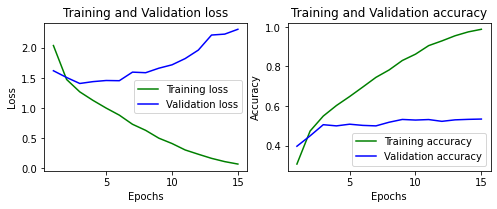

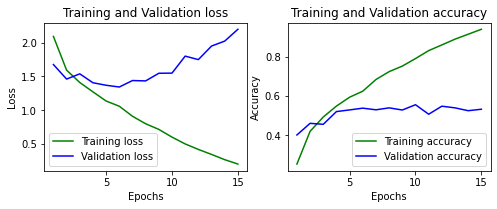

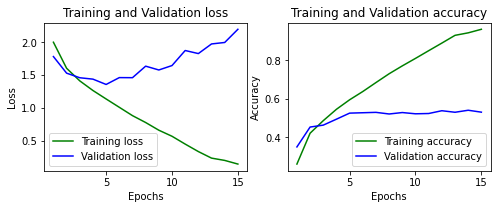

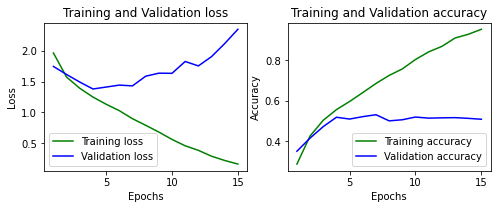

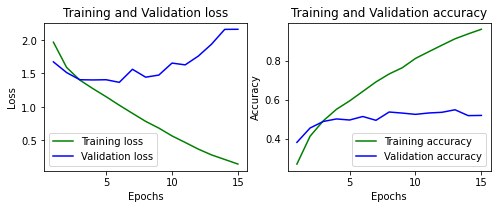

In [19]:
def loses_acc2(history):
    for i in range(len(histories1)):
        
        # Plot loss and val loss
        plt.subplot(221)
        loss_train = histories1[i].history['loss']
        loss_val = histories1[i].history['val_loss']
        epochs = range(1,16)
        plt.plot(epochs, loss_train, 'g', label='Training loss')
        plt.plot(epochs, loss_val, 'b', label='Validation loss')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        
        #Plot accuracy and val acc
        plt.subplot(222)
        loss_train = histories1[i].history['accuracy']
        loss_val = histories1[i].history['val_accuracy']
        epochs = range(1,16)
        plt.plot(epochs, loss_train, 'g', label='Training accuracy')
        plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()
        
loses_acc2(histories1) 

### 5. Improve the architecture by introducing more convolutional and corresponding subsampling layers.

In [20]:
# define improved model with more layers

def define_layer_model():
    
    layer_model = Sequential()
    #We add a convolutional layer with the same parameters
    layer_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
    layer_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    layer_model.add(MaxPool2D((2, 2)))
    # Here we add a convolutinal block with two convolutional layers and 64 output channels
    # And a maxpooling operation
    layer_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    layer_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    layer_model.add(MaxPool2D((2, 2)))
    layer_model.add(Flatten())
    layer_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    layer_model.add(Dense(10, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    layer_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return layer_model

model = define_layer_model()

In [21]:
# evaluate a model using k-fold cross-validation

def evaluate_layer_model(dataX, dataY, n_folds=5):
    scores2, histories2 = list(), list()
    
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        
        # define model
        layer_model = define_layer_model()
    
        # select rows for train and test
        train_X, train_Y, test_X, test_Y = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    
        # fit model
        history = layer_model.fit(train_X, train_Y, epochs=15, batch_size=40, validation_data=(test_X, test_Y), verbose=0)
    
        # evaluate model
        _, acc = layer_model.evaluate(test_X, test_Y, verbose=0)
        print('> %.3f' % (acc * 100.0))
    
        # stores scores
        scores2.append(acc)
        histories2.append(history)
    return scores2, histories2

In [22]:
# evaluate layer model - accuracy of each fold

scores2, histories2 = evaluate_layer_model(test_X, test_Y) 

> 53.350
> 55.500
> 54.300
> 51.150
> 56.050


In [23]:
#Average of the 5 folds

print('Accuracy: mean=%.3f' % (np.mean(scores2)*100))

Accuracy: mean=54.070


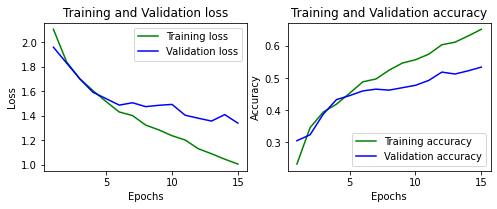

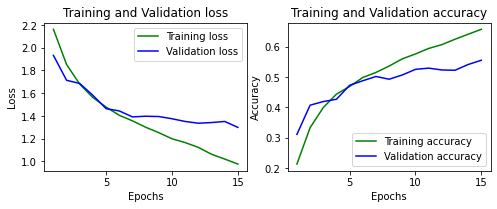

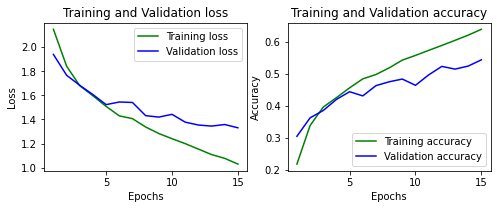

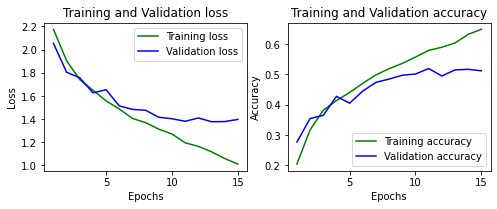

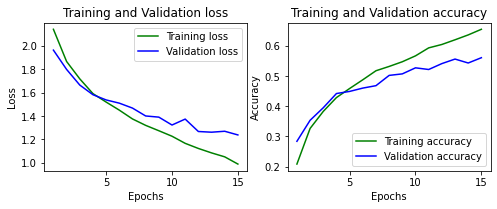

In [24]:
def loses_acc3(history):
    for i in range(len(histories2)):
        
        # Plot loss and val loss
        plt.subplot(221)
        loss_train = histories2[i].history['loss']
        loss_val = histories2[i].history['val_loss']
        epochs = range(1,16)
        plt.plot(epochs, loss_train, 'g', label='Training loss')
        plt.plot(epochs, loss_val, 'b', label='Validation loss')
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
        
        #Plot accuracy and val acc
        plt.subplot(222)
        loss_train = histories2[i].history['accuracy']
        loss_val = histories2[i].history['val_accuracy']
        epochs = range(1,16)
        plt.plot(epochs, loss_train, 'g', label='Training accuracy')
        plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
        plt.title('Training and Validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()
        
loses_acc3(histories2) 

### 6. Your final code should accept single image on the trained network and produce the output class.

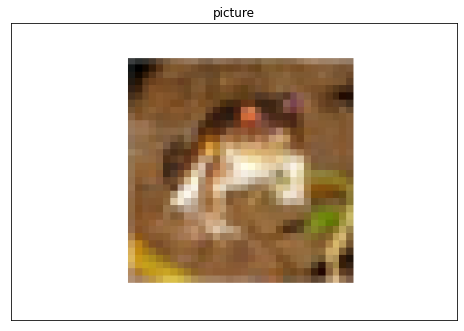

In [26]:
picture = cv2.cvtColor(cv2.imread("/content/drive/MyDrive/Classification/image_plot.png"), cv2.COLOR_BGR2RGB)
plt.imshow(picture)
plt.title('picture'), plt.xticks([]), plt.yticks([])
plt.show()

In [27]:
picture_path = "/content/drive/MyDrive/Classification/image_plot.png"

#load image and match the source size with target size
pic = tf.keras.preprocessing.image.load_img(picture_path, target_size=(32, 32))

#Convert image to 3D Numpy Array
pic_array = tf.keras.preprocessing.image.img_to_array(pic)

#Add the fourth dimension, for number of images
pic_array = tf.expand_dims(pic_array, 0) 

# Make prediction
predictions = model.predict(pic_array)
score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(cifar10_classes[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to horse with a 23.20 percent confidence.
